- Convolution and Pooling

  image (lenght, width, channel) 처리에 특화 (Channel : 만약 이미지가 흑백이라면 1, 컬러라면 3 rgb)

  kernel을 image에 대입하여 여러 번의 step을 통해 feature map을 획득

  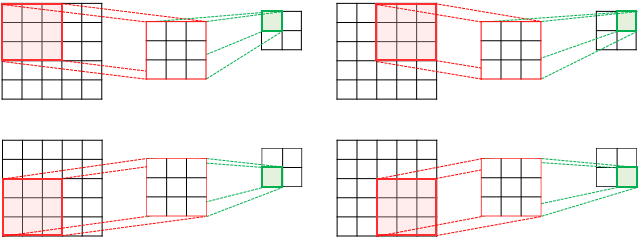

  Padding : convolution 이후에도 feature map의 크기를 동일하게 유지시키고 싶다면 padding 활용

  다수의 channel : convolution을 channel마다 수행 후 그 결과를 모두 더해 최종 feature map 획득

  Pooling : feature map을 다운샘플링하여 크기를 줄인다. ex) max pooling, average pooling


- CNN으로 MNIST 

  하나의 합성곱층 : 합성곱 nn.Conv2d + 활성화 함수 nn.ReLU + 맥스풀링 nn.MAxPoold2d
  

In [14]:
import torch
import torch.nn as nn

input = torch.Tensor(1,1,28,28) # batch size, channel, height, width

con1 = nn.Conv2d(1,32,3,padding=1) # input channel, pull off channel, kernel size
print(con1)
con2 = nn.Conv2d(32,64,3,padding=1)
pool = nn.MaxPool2d(2)
pool

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [15]:
out = con1(input)
out.shape

torch.Size([1, 32, 28, 28])

In [16]:
out = pool(out)
out.shape

torch.Size([1, 32, 14, 14])

In [18]:
out = pool(con2(out))
out.shape

torch.Size([1, 64, 7, 7])

In [20]:
out = out.view(out.size(0),-1) # 첫 배치 차원만 고정
out.shape

torch.Size([1, 3136])

In [21]:
# Full-Connected layer 전결합층
fc = nn.Linear(3136,10) # input dim, output dim
out = fc(out)
out.shape

torch.Size([1, 10])

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

device = 'cuda'
learning_rate = 0.001
training_epochs = 15
batch_size = 100

mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(), 
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', 
                         train=False, 
                         transform=transforms.ToTensor(), 
                         download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [6]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.fc = torch.nn.Linear(7*7*64,10,bias=True)

    torch.nn.init.xavier_uniform_(self.fc.weight) # 전결합층 가중치 초기화

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1)
    out = self.fc(out)
    return out

In [7]:
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
total_batch = len(data_loader)

for epoch in range(training_epochs):
  avg_cost = 0
  for X,Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    h = model(X)
    cost = criterion(h,Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch

  print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.212517858
[Epoch:    2] cost = 0.062498536
[Epoch:    3] cost = 0.0460295752
[Epoch:    4] cost = 0.037506111
[Epoch:    5] cost = 0.0299679786
[Epoch:    6] cost = 0.0255187284
[Epoch:    7] cost = 0.020844955
[Epoch:    8] cost = 0.0181572046
[Epoch:    9] cost = 0.0149084507
[Epoch:   10] cost = 0.0130525948
[Epoch:   11] cost = 0.0102395127
[Epoch:   12] cost = 0.00976447109
[Epoch:   13] cost = 0.00798934791
[Epoch:   14] cost = 0.00788217317
[Epoch:   15] cost = 0.00599603029


In [8]:
# test
with torch.no_grad():
  X_test = mnist_test.test_data.view(len(mnist_test),1,28,28).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  prediction = model(X_test)
  correct_prediction = torch.argmax(prediction,1) == Y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.988599956035614


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


- convolutin 2d 구현

In [1]:
import numpy as np
np.set_printoptions(linewidth=np.inf) # array 한 줄에 출력

def Conv2D(image, out_channels, kernel, padding=0, strides=1): # strides : 필터 적용 간격
 
    image_channel, image_height, image_width = image.shape[0], image.shape[1], image.shape[2] # channel : colors

    kernel_channel, kernel_height, kernel_width = image_channel, kernel[0], kernel[1]
    kernel = np.random.random((image_channel, kernel_height, kernel_width))    
    
    output_height = int(((image_height - kernel_height + 2 * padding) / strides) + 1)
    output_width= int(((image_width - kernel_width + 2 * padding) / strides) + 1)
    output_channel = out_channels
    
    output = np.zeros((output_channel, output_height, output_width)) # 0으로 초기화

    # create zero-padded input
    if padding != 0:
        imagePadded = np.zeros((image_channel, image_height + padding * 2, image_width + padding * 2)) # 앞 뒤 * 2
        imagePadded[:, padding:(-1*padding), padding:(-1*padding)] = image
    
    print('='*50)
    print('imagePadded')
    print(f'imagepadded shape : {imagePadded.shape}')
    print(imagePadded)

    # convolution 2D
    for z in range(0, output_channel):
        output_per_channel = np.zeros((output_height, output_width))
        
        for y in range(0, output_height):
            if (y*strides + kernel_height) <= imagePadded.shape[1]: # 연산 범위

                for x in range(0, output_width):                
                    if (x*strides + kernel_width) <= imagePadded.shape[2]:
                        output_per_channel[y][x] = np.sum(imagePadded[:,
                                                               y*strides : y*strides + kernel_height,
                                                               x*strides : x*strides + kernel_width] * kernel).astype(np.float32)
        output[z, :, :] = output_per_channel
    
    print('='*50)
    print('output')
    print(f'output shape : {output.shape}')
    print(output)
    print('='*50)

    return output

image = np.random.random((3, 5, 5))
output = Conv2D(image, 6, (3, 3), padding=1, strides=1)

imagePadded
imagepadded shape : (3, 7, 7)
[[[0.         0.         0.         0.         0.         0.         0.        ]
  [0.         0.61621155 0.57812819 0.30166475 0.86373294 0.92937941 0.        ]
  [0.         0.91329425 0.86167296 0.65855926 0.53321161 0.44240353 0.        ]
  [0.         0.03574627 0.1680656  0.60329462 0.98509211 0.7322033  0.        ]
  [0.         0.44324643 0.99653768 0.45786033 0.63090656 0.38599437 0.        ]
  [0.         0.65333979 0.61628986 0.98087399 0.85325517 0.99681194 0.        ]
  [0.         0.         0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.         0.         0.        ]
  [0.         0.8806529  0.88582803 0.54248838 0.30592811 0.34585324 0.        ]
  [0.         0.02556487 0.16721171 0.72632595 0.17767696 0.64961242 0.        ]
  [0.         0.48035262 0.16493177 0.53205681 0.13519219 0.98804217 0.        ]
  [0.         0.52377705 0.54929544 0.75396585 0.31704801 0.27667